# Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [1]:
import joblib

(A, terms, snippets) = joblib.load("cenario1-tweets-tfidf.pkl")

print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 274297 X 6414 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [2]:
kmin, kmax = 5, 20

Apply NMF for each of these values:

In [3]:
from sklearn import decomposition

topic_models = []

# try each value of k
for k in range(kmin, kmax + 1, 5):
    print("Applying NMF for k=%d ..." % k)
    # run NMF
    model = decomposition.NMF(init="nndsvd", n_components=k)
    W = model.fit_transform(A)
    H = model.components_
    # store for later
    topic_models.append((k, W, H))

Applying NMF for k=5 ...
Applying NMF for k=10 ...
Applying NMF for k=15 ...
Applying NMF for k=20 ...


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

**Note:** If you want to skip this step, a pre-built Word2Vec model for the sample dataset [is also provided here for download](http://erdos.ucd.ie/files/pydata/w2v-model.bin) (71MB).

We read the documents from the input file again:

In [4]:
import os.path

raw_documents = []

with open(os.path.join("../../././../../../data-pre-processing/2csv/cenario1_8M2020_tweets_pt.txt"), "r") as fin:
    for line in fin.readlines():
        raw_documents.append(line.strip().lower())

print("Read %d raw text documents" % len(raw_documents))

Read 274297 raw text documents


Read the custom stopword list:

In [5]:
custom_stop_words = []

with open("portuguese.txt", "r") as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 231 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [6]:
import re


class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append(tok)
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [7]:
import gensim

In [8]:
docgen = TokenGenerator(raw_documents, custom_stop_words)

# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [9]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 6468 terms


Save for later use, so that we do not need to rebuild it:

In [10]:
w2v_model.save("cenario1_w2v-model.bin")

In [11]:
# To re-load this model, run
# w2v_model = gensim.models.Word2Vec.load("cenario1_w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [12]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [13]:
import numpy as np


def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index, :])[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    
    return top_terms

Now process each of the models for different values of *k*:

# 5

In [37]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 5))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.4307
K=10: Coherence=0.4005
K=15: Coherence=0.4044
K=20: Coherence=0.4342


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

In [38]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

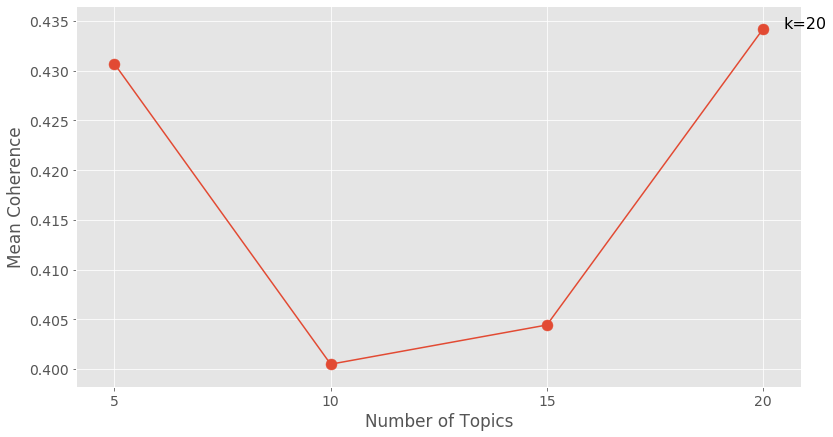

In [39]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 10

In [40]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.4037
K=10: Coherence=0.3845
K=15: Coherence=0.3640
K=20: Coherence=0.3775


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


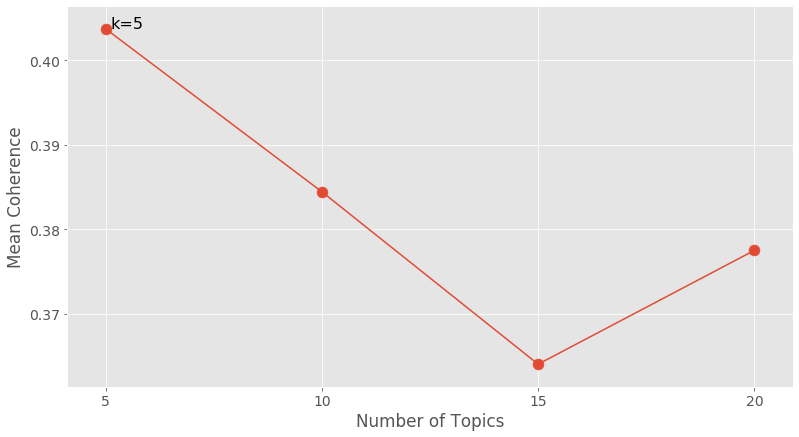

In [41]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 15 

In [42]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 15))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


K=05: Coherence=0.3531
K=10: Coherence=0.3482
K=15: Coherence=0.3227
K=20: Coherence=0.3205


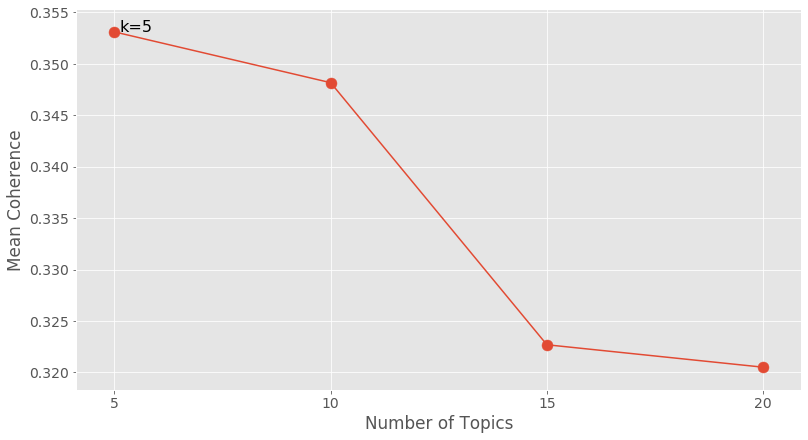

In [43]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 20

In [44]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 20))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


K=05: Coherence=0.2930
K=10: Coherence=0.3271
K=15: Coherence=0.2861
K=20: Coherence=0.2864


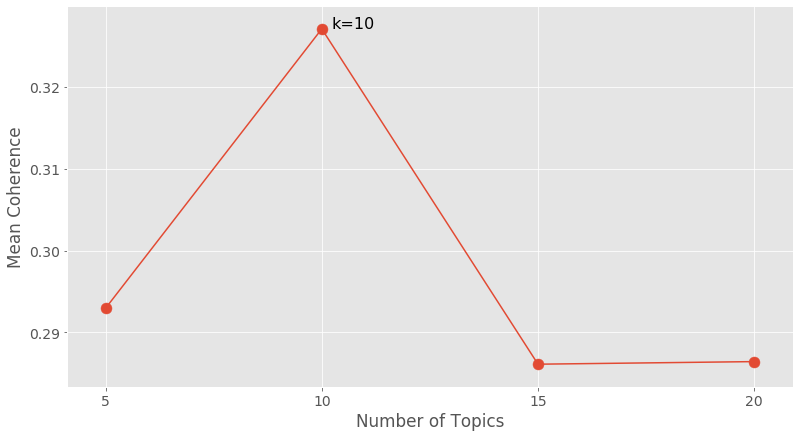

In [45]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

In [17]:
k = 5 # best_k

# get the model that we generated earlier.
W = topic_models[0][1]
H = topic_models[0][2]

Display the topic descriptors for this model:

In [18]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas
Topic 02: onibus, lembrancinha, enfeita, entram, motorista
Topic 03: faltar, pode, internacional, mulher, dia
Topic 04: incriveis, mulheres, feliz, esquecam, dia
Topic 05: feliz, dia, mulher, iconico, internacional


In [19]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas, carbonizadas, aproximadamente, estarem, fabrica, morreram
Topic 02: onibus, lembrancinha, enfeita, entram, motorista, semana, dar, ano, mulheres, internacional
Topic 03: faltar, pode, internacional, mulher, dia, feliz, marco, feministo, depositar, 10k
Topic 04: incriveis, mulheres, feliz, esquecam, dia, sonham, brisa, sorte, manas, querem
Topic 05: feliz, dia, mulher, iconico, internacional, importancia, relembrar, video, vamos, feminista


In [20]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas, carbonizadas, aproximadamente, estarem, fabrica, morreram, york, greve, nova, declarou, dia
Topic 02: onibus, lembrancinha, enfeita, entram, motorista, semana, dar, ano, mulheres, internacional, mulher, dia, feliz, hoje, parabens
Topic 03: faltar, pode, internacional, mulher, dia, feliz, marco, feministo, depositar, 10k, conta, algum, obrigado, homem, hoje
Topic 04: incriveis, mulheres, feliz, esquecam, dia, sonham, brisa, sorte, manas, querem, dao, donas, tudo, fazem, nunca
Topic 05: feliz, dia, mulher, iconico, internacional, importancia, relembrar, video, vamos, feminista, tok, tik, possivel, hoje, sobre


In [21]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas, carbonizadas, aproximadamente, estarem, fabrica, morreram, york, greve, nova, declarou, dia, homenagem, onde, internacional, mulher, quiser
Topic 02: onibus, lembrancinha, enfeita, entram, motorista, semana, dar, ano, mulheres, internacional, mulher, dia, feliz, hoje, parabens, dias, quiser, ser, forca, lugar
Topic 03: faltar, pode, internacional, mulher, dia, feliz, marco, feministo, depositar, 10k, conta, algum, obrigado, homem, hoje, parabens, quiser, lugar, thread, amanha
Topic 04: incriveis, mulheres, feliz, esquecam, dia, sonham, brisa, sorte, manas, querem, dao, donas, tudo, fazem, nunca, disso, juntas, enaltecer, maravilhosas, lindas
Topic 05: feliz, dia, mulher, iconico, internacional, importancia, relembrar, video, vamos, feminista, tok, tik, possivel, hoje, sobre, mulheres, luta, mundo, bom, flores


# 10

In [22]:
k = 10 # best_k

# get the model that we generated earlier.
W = topic_models[1][1]
H = topic_models[1][2]

In [23]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas
Topic 02: onibus, lembrancinha, enfeita, entram, motorista
Topic 03: faltar, pode, internacional, mulher, dia
Topic 04: incriveis, mulheres, esquecam, sonham, brisa
Topic 05: iconico, relembrar, vamos, importancia, video
Topic 06: feliz, dia, mulher, internacional, mulheres
Topic 07: tik, tok, possivel, feminista, feliz
Topic 08: deveria, menos, vez, vida, mundo
Topic 09: sobre, hoje, bom, respeitarem, numeros
Topic 10: vou, falar, rir, repense, parca


In [24]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas, carbonizadas, aproximadamente, estarem, fabrica, morreram
Topic 02: onibus, lembrancinha, enfeita, entram, motorista, semana, dar, ano, mulheres, internacional
Topic 03: faltar, pode, internacional, mulher, dia, marco, feministo, depositar, 10k, conta
Topic 04: incriveis, mulheres, esquecam, sonham, brisa, sorte, manas, querem, dao, donas
Topic 05: iconico, relembrar, vamos, importancia, video, internacional, mulher, dia, melhor, thread
Topic 06: feliz, dia, mulher, internacional, mulheres, guerreiras, lugar, quiser, forca, parabens
Topic 07: tik, tok, possivel, feminista, feliz, trabalhassem, trataram, donalds, machos, folga
Topic 08: deveria, menos, vez, vida, mundo, video, ver, assistir, sinto, melhor
Topic 09: sobre, hoje, bom, respeitarem, numeros, mostram, presentes, segue, flores, data
Topic 10: vou, falar, rir, repense, parca, questionar, trai, babaca, pano, roupa


In [25]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas, carbonizadas, aproximadamente, estarem, fabrica, morreram, york, greve, nova, declarou, onde
Topic 02: onibus, lembrancinha, enfeita, entram, motorista, semana, dar, ano, mulheres, internacional, mulher, dia, hoje, parabens, thread
Topic 03: faltar, pode, internacional, mulher, dia, marco, feministo, depositar, 10k, conta, algum, homem, thread, obrigado, hoje
Topic 04: incriveis, mulheres, esquecam, sonham, brisa, sorte, manas, querem, dao, donas, fazem, disso, tudo, nunca, juntas
Topic 05: iconico, relembrar, vamos, importancia, video, internacional, mulher, dia, melhor, thread, poder, grey, homanagem, reafirmou, anatomy
Topic 06: feliz, dia, mulher, internacional, mulheres, guerreiras, lugar, quiser, forca, parabens, inclusive, marco, mjsp, publica, justica
Topic 07: tik, tok, possivel, feminista, feliz, trabalhassem, trataram, donalds, machos, folga, colocou, lembro, ato, ainda, mulheres
Topic 08: deveria, menos, vez, vid

In [26]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas, carbonizadas, aproximadamente, estarem, fabrica, morreram, york, greve, nova, declarou, onde, homenagem, dia, internacional, mulher, quiser
Topic 02: onibus, lembrancinha, enfeita, entram, motorista, semana, dar, ano, mulheres, internacional, mulher, dia, hoje, parabens, thread, historia, ato, folga, colocou, lembro
Topic 03: faltar, pode, internacional, mulher, dia, marco, feministo, depositar, 10k, conta, algum, homem, thread, obrigado, hoje, lembro, folga, colocou, donalds, trabalhassem
Topic 04: incriveis, mulheres, esquecam, sonham, brisa, sorte, manas, querem, dao, donas, fazem, disso, tudo, nunca, juntas, enaltecer, maravilhosas, coerentes, assis, bicalho
Topic 05: iconico, relembrar, vamos, importancia, video, internacional, mulher, dia, melhor, thread, poder, grey, homanagem, reafirmou, anatomy, comeco, vezes, fazer, vitima, cena
Topic 06: feliz, dia, mulher, internacional, mulheres, guerreiras, lugar, quiser, forca

# 15

In [27]:
k = 15 # best_k

# get the model that we generated earlier.
W = topic_models[2][1]
H = topic_models[2][2]

In [28]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas
Topic 02: onibus, lembrancinha, enfeita, entram, motorista
Topic 03: faltar, pode, internacional, mulher, dia
Topic 04: incriveis, mulheres, esquecam, sonham, brisa
Topic 05: iconico, relembrar, vamos, importancia, video
Topic 06: feliz, dia, internacional, mulher, mulheres
Topic 07: tik, tok, possivel, feminista, feliz
Topic 08: deveria, menos, vez, vida, mundo
Topic 09: sobre, bom, respeitarem, numeros, mostram
Topic 10: vou, falar, vestir, ser, ouvido
Topic 11: quiser, lugar, mjsp, inclusive, seguranca
Topic 12: donalds, trabalhassem, trataram, folga, machos
Topic 13: thread, importantes, negras, historia, brasileira
Topic 14: hoje, ser, dias, repense, parca
Topic 15: nunca, esquecer, julgue, amanha, violencia


In [29]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas, carbonizadas, aproximadamente, estarem, fabrica, morreram
Topic 02: onibus, lembrancinha, enfeita, entram, motorista, semana, dar, ano, mulheres, internacional
Topic 03: faltar, pode, internacional, mulher, dia, marco, feministo, depositar, 10k, conta
Topic 04: incriveis, mulheres, esquecam, sonham, brisa, sorte, manas, querem, dao, donas
Topic 05: iconico, relembrar, vamos, importancia, video, internacional, mulher, dia, melhor, cena
Topic 06: feliz, dia, internacional, mulher, mulheres, guerreiras, marco, parabens, obrigado, mundo
Topic 07: tik, tok, possivel, feminista, feliz, mulheres, domingo, explosao, vestia, opressor
Topic 08: deveria, menos, vez, vida, mundo, video, ver, assistir, sinto, melhor
Topic 09: sobre, bom, respeitarem, numeros, mostram, presentes, segue, data, direitos, luta
Topic 10: vou, falar, vestir, ser, ouvido, disseram, fio, algumas, sororidade, viveu
Topic 11: quiser, lugar, mjsp, inclusive, segura

In [30]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas, carbonizadas, aproximadamente, estarem, fabrica, morreram, york, greve, nova, declarou, homenagem
Topic 02: onibus, lembrancinha, enfeita, entram, motorista, semana, dar, ano, mulheres, internacional, mulher, dia, parabens, amanha, brasil
Topic 03: faltar, pode, internacional, mulher, dia, marco, feministo, depositar, 10k, conta, algum, homem, obrigado, thread, amanha
Topic 04: incriveis, mulheres, esquecam, sonham, brisa, sorte, manas, querem, dao, donas, tudo, fazem, disso, enaltecer, juntas
Topic 05: iconico, relembrar, vamos, importancia, video, internacional, mulher, dia, melhor, cena, poder, grey, homanagem, reafirmou, anatomy
Topic 06: feliz, dia, internacional, mulher, mulheres, guerreiras, marco, parabens, obrigado, mundo, cada, ser, cena, dias, votou
Topic 07: tik, tok, possivel, feminista, feliz, mulheres, domingo, explosao, vestia, opressor, culpa, estado, estuprador, chile, homem
Topic 08: deveria, menos, vez, v

In [31]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas, carbonizadas, aproximadamente, estarem, fabrica, morreram, york, greve, nova, declarou, homenagem, onde, dia, internacional, mulher, obrigado
Topic 02: onibus, lembrancinha, enfeita, entram, motorista, semana, dar, ano, mulheres, internacional, mulher, dia, parabens, amanha, brasil, luta, marco, ruas, contra, homens
Topic 03: faltar, pode, internacional, mulher, dia, marco, feministo, depositar, 10k, conta, algum, homem, obrigado, thread, amanha, julgue, parabens, violencia, manu, mudar
Topic 04: incriveis, mulheres, esquecam, sonham, brisa, sorte, manas, querem, dao, donas, tudo, fazem, disso, enaltecer, juntas, maravilhosas, coerentes, assis, bicalho, kalimann
Topic 05: iconico, relembrar, vamos, importancia, video, internacional, mulher, dia, melhor, cena, poder, grey, homanagem, reafirmou, anatomy, comeco, vezes, fazer, marco, paciente
Topic 06: feliz, dia, internacional, mulher, mulheres, guerreiras, marco, parabens, ob

# 20

In [32]:
k = 20 # best_k

# get the model that we generated earlier.
W = topic_models[3][1]
H = topic_models[3][2]

In [33]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas
Topic 02: onibus, lembrancinha, enfeita, entram, motorista
Topic 03: faltar, pode, internacional, mulher, dia
Topic 04: incriveis, mulheres, esquecam, sonham, brisa
Topic 05: iconico, relembrar, vamos, importancia, video
Topic 06: feliz, dia, internacional, mulher, mulheres
Topic 07: tik, tok, possivel, feminista, feliz
Topic 08: deveria, menos, vez, vida, mundo
Topic 09: sobre, respeitarem, bom, numeros, mostram
Topic 10: vou, falar, ser, vestir, ouvido
Topic 11: quiser, lugar, mjsp, inclusive, seguranca
Topic 12: donalds, trabalhassem, trataram, folga, machos
Topic 13: thread, importantes, brasileira, negras, historia
Topic 14: hoje, ser, repense, parca, rir
Topic 15: nunca, esquecer, julgue, violencia, amanha
Topic 16: manu, gavassi, margens, falso, caralho
Topic 17: queremos, nao, parabens, lembretes, fofa
Topic 18: reafirmou, homanagem, anatomy, grey, comeco
Topic 19: mulheres, guerreiras, obrigado, dia, parabens
Topic 2

In [34]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas, carbonizadas, aproximadamente, estarem, fabrica, morreram
Topic 02: onibus, lembrancinha, enfeita, entram, motorista, semana, dar, ano, mulheres, internacional
Topic 03: faltar, pode, internacional, mulher, dia, feministo, depositar, 10k, conta, algum
Topic 04: incriveis, mulheres, esquecam, sonham, brisa, sorte, manas, querem, dao, donas
Topic 05: iconico, relembrar, vamos, importancia, video, internacional, mulher, dia, melhor, cena
Topic 06: feliz, dia, internacional, mulher, mulheres, domingo, marco, votou, enfia, ser
Topic 07: tik, tok, possivel, feminista, feliz, mulheres, explosao, vestia, opressor, culpa
Topic 08: deveria, menos, vez, vida, mundo, video, ver, assistir, sinto, melhor
Topic 09: sobre, respeitarem, bom, numeros, mostram, presentes, segue, data, direitos, flores
Topic 10: vou, falar, ser, vestir, ouvido, disseram, sororidade, fio, algumas, viveu
Topic 11: quiser, lugar, mjsp, inclusive, seguranca, public

In [35]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas, carbonizadas, aproximadamente, estarem, fabrica, morreram, york, greve, nova, declarou, homenagem
Topic 02: onibus, lembrancinha, enfeita, entram, motorista, semana, dar, ano, mulheres, internacional, mulher, dia, parabens, julgue, quero
Topic 03: faltar, pode, internacional, mulher, dia, feministo, depositar, 10k, conta, algum, homem, marco, julgue, amanha, obrigado
Topic 04: incriveis, mulheres, esquecam, sonham, brisa, sorte, manas, querem, dao, donas, disso, fazem, juntas, tudo, enaltecer
Topic 05: iconico, relembrar, vamos, importancia, video, internacional, mulher, dia, melhor, cena, vitima, paciente, amo, perfeito, violencia
Topic 06: feliz, dia, internacional, mulher, mulheres, domingo, marco, votou, enfia, ser, linda, principalmente, dias, bom, especial
Topic 07: tik, tok, possivel, feminista, feliz, mulheres, explosao, vestia, opressor, culpa, domingo, estado, homem, estuprador, chile
Topic 08: deveria, menos, vez,

In [36]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: marco, mulheres, tecelagem, trabalhavam, trancadas, carbonizadas, aproximadamente, estarem, fabrica, morreram, york, greve, nova, declarou, homenagem, onde, dia, internacional, mulher, thread
Topic 02: onibus, lembrancinha, enfeita, entram, motorista, semana, dar, ano, mulheres, internacional, mulher, dia, parabens, julgue, quero, parabenizar, amanha, deus, marido, respeito
Topic 03: faltar, pode, internacional, mulher, dia, feministo, depositar, 10k, conta, algum, homem, marco, julgue, amanha, obrigado, violencia, thread, parabens, ser, marido
Topic 04: incriveis, mulheres, esquecam, sonham, brisa, sorte, manas, querem, dao, donas, disso, fazem, juntas, tudo, enaltecer, maravilhosas, coerentes, assis, bicalho, kalimann
Topic 05: iconico, relembrar, vamos, importancia, video, internacional, mulher, dia, melhor, cena, vitima, paciente, amo, perfeito, violencia, marco, enxergava, greysloan, corredor, uniram
Topic 06: feliz, dia, internacional, mulher, mulheres, domingo, marco, 